In [1]:
from datasets import load_dataset

ds = load_dataset("KisanVaani/agriculture-qa-english-only")

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

df = pd.DataFrame(ds['train'])

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("fill-mask", model="recobo/agriculture-bert-uncased")

# Create a masked version of the question to test the model's agricultural knowledge
question = "Which crop is the major source of food in africa?"
masked_question = "Which crop is the major source of food in africa? [MASK]"

# Use the fill-mask pipeline to predict the masked token
predictions = pipe(masked_question, top_k=10)

print(f"Original question: {question}")
print(f"Masked question: {masked_question}")
print(f"\nTop 10 predictions for [MASK]:")
print("-" * 40)

for i, pred in enumerate(predictions, 1):
    print(f"{i:2d}. {pred['token_str']:15} (confidence: {pred['score']:.4f})")

# Check if 'crop' is in the predictions
crop_found = any('crop' in pred['token_str'].lower() for pred in predictions)
print(f"\nIs 'crop' in predictions? {crop_found}")

# Also test with a more specific agricultural context
masked_question2 = "Maize is the major [MASK] in africa."
predictions2 = pipe(masked_question2, top_k=5)

print(f"\n\nAlternative test:")
print(f"Masked sentence: {masked_question2}")
print(f"Top 5 predictions:")
for i, pred in enumerate(predictions2, 1):
    print(f"{i}. {pred['token_str']:15} (confidence: {pred['score']:.4f})")

Device set to use mps:0


In [5]:
# Let's first explore the dataset structure
print("Dataset structure:")
print(f"Number of training examples: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few examples:")
print(df.head())

Dataset structure:
Number of training examples: 22615
Columns: ['question', 'answers']

First few examples:
                                            question  \
0         why is crop rotation important in farming?   
1  What farming practice helps prevent soil erosion?   
2                              what is crop rotation   
3      what are the different methods of irrigation?   
4                          why is soil health vital?   

                                             answers  
0  This helps to prevent soil erosion and depleti...  
1                                      Crop Rotation  
2  Crop rotation is the practice of growing a ser...  
3  surface irrigation, drip irrigation, and sprin...  
4  Soil health is critical to crop growth and pro...  


In [6]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Load the model and tokenizer properly for evaluation
model_name = "recobo/agriculture-bert-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

print(f"Model loaded: {model_name}")
print(f"Tokenizer vocab size: {len(tokenizer)}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

Model loaded: recobo/agriculture-bert-uncased
Tokenizer vocab size: 31090
Model parameters: 109,951,090
Using device: cpu


In [7]:
def evaluate_masked_language_modeling(model, tokenizer, texts, num_samples=500):
    """
    Evaluate the model's performance on masked language modeling task
    """
    model.eval()
    total_loss = 0
    total_accuracy = 0
    total_top5_accuracy = 0
    valid_samples = 0
    
    # Take a random sample of texts
    sample_texts = random.sample(texts, min(num_samples, len(texts)))
    
    with torch.no_grad():
        for text in sample_texts:
            # Clean and prepare text
            text = str(text).strip()
            if len(text) < 10:  # Skip very short texts
                continue
                
            # Tokenize
            tokens = tokenizer.tokenize(text)
            if len(tokens) < 5:  # Need at least 5 tokens to mask one
                continue
                
            # Randomly mask a token (not special tokens)
            maskable_positions = [i for i, token in enumerate(tokens) 
                                if not token.startswith('[') and not token.startswith('#')]
            
            if not maskable_positions:
                continue
                
            mask_pos = random.choice(maskable_positions)
            original_token = tokens[mask_pos]
            tokens[mask_pos] = '[MASK]'
            
            # Convert back to string and encode
            masked_text = tokenizer.convert_tokens_to_string(tokens)
            encoded = tokenizer(masked_text, return_tensors='pt', truncation=True, max_length=512)
            
            # Find the mask token position in the encoded sequence
            mask_token_index = torch.where(encoded['input_ids'] == tokenizer.mask_token_id)[1]
            
            if len(mask_token_index) == 0:
                continue
                
            # Get model predictions
            outputs = model(**encoded)
            predictions = outputs.logits
            
            # Get the original token id
            original_token_id = tokenizer.convert_tokens_to_ids(original_token)
            
            # Calculate loss
            mask_token_logits = predictions[0, mask_token_index, :]
            loss = torch.nn.functional.cross_entropy(mask_token_logits, torch.tensor([original_token_id]))
            total_loss += loss.item()
            
            # Calculate accuracy
            predicted_token_ids = torch.argsort(mask_token_logits, dim=-1, descending=True)
            
            # Top-1 accuracy
            if predicted_token_ids[0, 0].item() == original_token_id:
                total_accuracy += 1
            
            # Top-5 accuracy
            if original_token_id in predicted_token_ids[0, :5].tolist():
                total_top5_accuracy += 1
                
            valid_samples += 1
    
    if valid_samples == 0:
        return None
        
    avg_loss = total_loss / valid_samples
    avg_accuracy = total_accuracy / valid_samples
    avg_top5_accuracy = total_top5_accuracy / valid_samples
    
    return {
        'average_loss': avg_loss,
        'top1_accuracy': avg_accuracy,
        'top5_accuracy': avg_top5_accuracy,
        'perplexity': np.exp(avg_loss),
        'samples_evaluated': valid_samples
    }

# Evaluate on questions and answers
print("Evaluating Masked Language Modeling...")
print("="*50)

# Combine questions and answers for evaluation
all_texts = df['question'].tolist() + df['answers'].tolist()

# Evaluate the model
mlm_results = evaluate_masked_language_modeling(model, tokenizer, all_texts, num_samples=200)

if mlm_results:
    print(f"Masked Language Modeling Results:")
    print(f"- Average Loss: {mlm_results['average_loss']:.4f}")
    print(f"- Perplexity: {mlm_results['perplexity']:.4f}")
    print(f"- Top-1 Accuracy: {mlm_results['top1_accuracy']:.4f} ({mlm_results['top1_accuracy']*100:.2f}%)")
    print(f"- Top-5 Accuracy: {mlm_results['top5_accuracy']:.4f} ({mlm_results['top5_accuracy']*100:.2f}%)")
    print(f"- Samples Evaluated: {mlm_results['samples_evaluated']}")
else:
    print("Could not evaluate masked language modeling")

Evaluating Masked Language Modeling...
Masked Language Modeling Results:
- Average Loss: 2.4796
- Perplexity: 11.9368
- Top-1 Accuracy: 0.5514 (55.14%)
- Top-5 Accuracy: 0.7514 (75.14%)
- Samples Evaluated: 185


In [8]:
def evaluate_agricultural_domain_knowledge(model, tokenizer, texts, num_samples=100):
    """
    Evaluate model's knowledge of agricultural terms and concepts
    """
    # Define agricultural terms that should be well understood
    agricultural_terms = [
        'crop', 'soil', 'irrigation', 'fertilizer', 'pesticide', 'harvest',
        'planting', 'farming', 'agriculture', 'livestock', 'cultivation',
        'rotation', 'organic', 'yield', 'drought', 'nitrogen', 'phosphorus',
        'potassium', 'seed', 'germination', 'photosynthesis', 'greenhouse',
        'tillage', 'composting', 'weeds', 'insects', 'disease', 'minerals'
    ]
    
    model.eval()
    results = defaultdict(list)
    
    # Sample texts containing agricultural terms
    sample_texts = random.sample(texts, min(num_samples, len(texts)))
    
    with torch.no_grad():
        for text in sample_texts:
            text = str(text).strip().lower()
            
            # Find sentences containing agricultural terms
            for term in agricultural_terms:
                if term in text:
                    # Create a masked version where the agricultural term is masked
                    masked_text = text.replace(term, '[MASK]', 1)
                    
                    # Tokenize and get predictions
                    encoded = tokenizer(masked_text, return_tensors='pt', truncation=True, max_length=512)
                    mask_token_index = torch.where(encoded['input_ids'] == tokenizer.mask_token_id)[1]
                    
                    if len(mask_token_index) == 0:
                        continue
                    
                    outputs = model(**encoded)
                    predictions = outputs.logits
                    mask_token_logits = predictions[0, mask_token_index, :]
                    
                    # Get top predictions
                    top_predictions = torch.topk(mask_token_logits, 10, dim=-1)
                    top_tokens = [tokenizer.decode(token_id) for token_id in top_predictions.indices[0]]
                    
                    # Check if the original term is in top predictions
                    original_term_id = tokenizer.convert_tokens_to_ids(term)
                    is_in_top10 = original_term_id in top_predictions.indices[0].tolist()
                    
                    results[term].append({
                        'original_text': text,
                        'masked_text': masked_text,
                        'top_predictions': top_tokens,
                        'is_correct_in_top10': is_in_top10
                    })
    
    # Calculate domain-specific metrics
    domain_metrics = {}
    for term, predictions in results.items():
        if predictions:
            accuracy = sum(p['is_correct_in_top10'] for p in predictions) / len(predictions)
            domain_metrics[term] = {
                'accuracy': accuracy,
                'samples': len(predictions)
            }
    
    return domain_metrics

# Evaluate domain knowledge
print("\nEvaluating Agricultural Domain Knowledge...")
print("="*50)

domain_results = evaluate_agricultural_domain_knowledge(model, tokenizer, all_texts, num_samples=150)

if domain_results:
    print(f"Agricultural Domain Knowledge Results:")
    print(f"Terms evaluated: {len(domain_results)}")
    
    # Sort by accuracy
    sorted_results = sorted(domain_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    
    total_accuracy = 0
    total_samples = 0
    
    print("\nTop performing agricultural terms:")
    for term, metrics in sorted_results[:10]:
        print(f"- {term}: {metrics['accuracy']:.3f} ({metrics['accuracy']*100:.1f}%) - {metrics['samples']} samples")
        total_accuracy += metrics['accuracy'] * metrics['samples']
        total_samples += metrics['samples']
    
    if total_samples > 0:
        overall_domain_accuracy = total_accuracy / total_samples
        print(f"\nOverall agricultural domain accuracy: {overall_domain_accuracy:.3f} ({overall_domain_accuracy*100:.1f}%)")
else:
    print("Could not evaluate domain knowledge")


Evaluating Agricultural Domain Knowledge...
Agricultural Domain Knowledge Results:
Terms evaluated: 23

Top performing agricultural terms:
- seed: 1.000 (100.0%) - 5 samples
- yield: 1.000 (100.0%) - 8 samples
- nitrogen: 1.000 (100.0%) - 1 samples
- phosphorus: 1.000 (100.0%) - 2 samples
- potassium: 1.000 (100.0%) - 1 samples
- rotation: 1.000 (100.0%) - 4 samples
- organic: 1.000 (100.0%) - 5 samples
- germination: 1.000 (100.0%) - 2 samples
- insects: 1.000 (100.0%) - 1 samples
- harvest: 1.000 (100.0%) - 1 samples

Overall agricultural domain accuracy: 1.000 (100.0%)


In [9]:
def evaluate_semantic_coherence(model, tokenizer, df, num_samples=100):
    """
    Evaluate semantic coherence between questions and answers using BERT embeddings
    """
    from sentence_transformers import SentenceTransformer
    
    # Use a sentence transformer for semantic similarity
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Sample question-answer pairs
    sample_df = df.sample(min(num_samples, len(df)))
    
    similarities = []
    
    for _, row in sample_df.iterrows():
        question = str(row['question']).strip()
        answer = str(row['answers']).strip()
        
        if len(question) > 5 and len(answer) > 5:
            # Get embeddings
            question_embedding = sentence_model.encode([question])
            answer_embedding = sentence_model.encode([answer])
            
            # Calculate cosine similarity
            similarity = cosine_similarity(question_embedding, answer_embedding)[0][0]
            similarities.append(similarity)
    
    return {
        'mean_similarity': np.mean(similarities),
        'std_similarity': np.std(similarities),
        'min_similarity': np.min(similarities),
        'max_similarity': np.max(similarities),
        'samples_evaluated': len(similarities)
    }

def evaluate_fill_mask_examples(pipe, texts, num_samples=20):
    """
    Evaluate the fill-mask pipeline on real agricultural texts
    """
    sample_texts = random.sample(texts, min(num_samples, len(texts)))
    examples = []
    
    for text in sample_texts:
        text = str(text).strip()
        words = text.split()
        
        if len(words) < 5:
            continue
            
        # Create a masked version by replacing a random word with [MASK]
        mask_idx = random.randint(1, len(words) - 2)  # Don't mask first/last word
        original_word = words[mask_idx]
        words[mask_idx] = '[MASK]'
        masked_text = ' '.join(words)
        
        try:
            # Get predictions
            predictions = pipe(masked_text, top_k=5)
            
            # Check if original word is in predictions
            predicted_words = [pred['token_str'] for pred in predictions]
            is_correct = original_word.lower() in [w.lower() for w in predicted_words]
            
            examples.append({
                'original_text': text,
                'masked_text': masked_text,
                'original_word': original_word,
                'predictions': predictions,
                'is_correct': is_correct
            })
            
        except Exception as e:
            continue
    
    return examples

# Install sentence-transformers if needed
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("Installing sentence-transformers...")
    import subprocess
    subprocess.check_call(["pip", "install", "sentence-transformers"])
    from sentence_transformers import SentenceTransformer

print("\nEvaluating Semantic Coherence...")
print("="*50)

# Evaluate semantic coherence
coherence_results = evaluate_semantic_coherence(model, tokenizer, df, num_samples=100)

print(f"Semantic Coherence Results:")
print(f"- Mean Q-A Similarity: {coherence_results['mean_similarity']:.4f}")
print(f"- Std Q-A Similarity: {coherence_results['std_similarity']:.4f}")
print(f"- Min Q-A Similarity: {coherence_results['min_similarity']:.4f}")
print(f"- Max Q-A Similarity: {coherence_results['max_similarity']:.4f}")
print(f"- Samples Evaluated: {coherence_results['samples_evaluated']}")

print("\nEvaluating Fill-Mask Examples...")
print("="*50)

# Evaluate fill-mask examples
mask_examples = evaluate_fill_mask_examples(pipe, all_texts, num_samples=15)

if mask_examples:
    correct_predictions = sum(1 for ex in mask_examples if ex['is_correct'])
    accuracy = correct_predictions / len(mask_examples)
    
    print(f"Fill-Mask Evaluation Results:")
    print(f"- Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"- Samples Evaluated: {len(mask_examples)}")
    
    print(f"\nSample Fill-Mask Examples:")
    for i, example in enumerate(mask_examples[:3]):
        print(f"\nExample {i+1}:")
        print(f"Original: {example['original_text'][:100]}...")
        print(f"Masked: {example['masked_text'][:100]}...")
        print(f"Target word: '{example['original_word']}'")
        print(f"Top predictions: {[pred['token_str'] for pred in example['predictions']]}")
        print(f"Correct: {example['is_correct']}")
else:
    print("Could not generate fill-mask examples")


Evaluating Semantic Coherence...
Semantic Coherence Results:
- Mean Q-A Similarity: 0.5359
- Std Q-A Similarity: 0.2178
- Min Q-A Similarity: 0.1323
- Max Q-A Similarity: 0.9071
- Samples Evaluated: 96

Evaluating Fill-Mask Examples...
Fill-Mask Evaluation Results:
- Accuracy: 0.6667 (66.67%)
- Samples Evaluated: 12

Sample Fill-Mask Examples:

Example 1:
Original: how can farmers control bacterial blight....
Masked: how can farmers control [MASK] blight....
Target word: 'bacterial'
Top predictions: ['fire', 'potato', 'late', 'leaf', 'bacterial']
Correct: True

Example 2:
Original: which variety was recommended for Northern region with shorter rains....
Masked: which variety was recommended for Northern [MASK] with shorter rains....
Target word: 'region'
Top predictions: ['areas', 'regions', 'districts', 'conditions', 'countries']
Correct: False

Example 3:
Original: what is High fructose corn syrup...
Masked: what [MASK] High fructose corn syrup...
Target word: 'is'
Top predictions: 


COMPREHENSIVE EVALUATION SUMMARY

1. MASKED LANGUAGE MODELING PERFORMANCE:
   • Perplexity: 11.94
   • Top-1 Accuracy: 55.1%
   • Top-5 Accuracy: 75.1%
   • Average Loss: 2.480

2. AGRICULTURAL DOMAIN KNOWLEDGE:
   • Overall Domain Accuracy: 82.7%
   • Terms Successfully Evaluated: 23
   • Best Performing Terms: seed, yield, nitrogen, phosphorus, potassium
   • Needs Improvement: tillage, weeds, cultivation

3. SEMANTIC COHERENCE (Q&A Relevance):
   • Mean Q-A Similarity: 0.536
   • Similarity Range: 0.132 - 0.907

4. FILL-MASK TASK PERFORMANCE:
   • Fill-Mask Accuracy: 66.7%
   • Examples Evaluated: 12

5. MODEL SPECIFICATIONS:
   • Model: recobo/agriculture-bert-uncased
   • Parameters: 109,951,090
   • Vocabulary Size: 31,090
   • Task: Masked Language Modeling

6. OVERALL PERFORMANCE RATING:
   • Composite Score: 0.577/1.000
   • Rating: NEEDS IMPROVEMENT

7. RECOMMENDATIONS:
   • Consider fine-tuning on more agricultural text data
   • Improve question-answer alignment in trainin

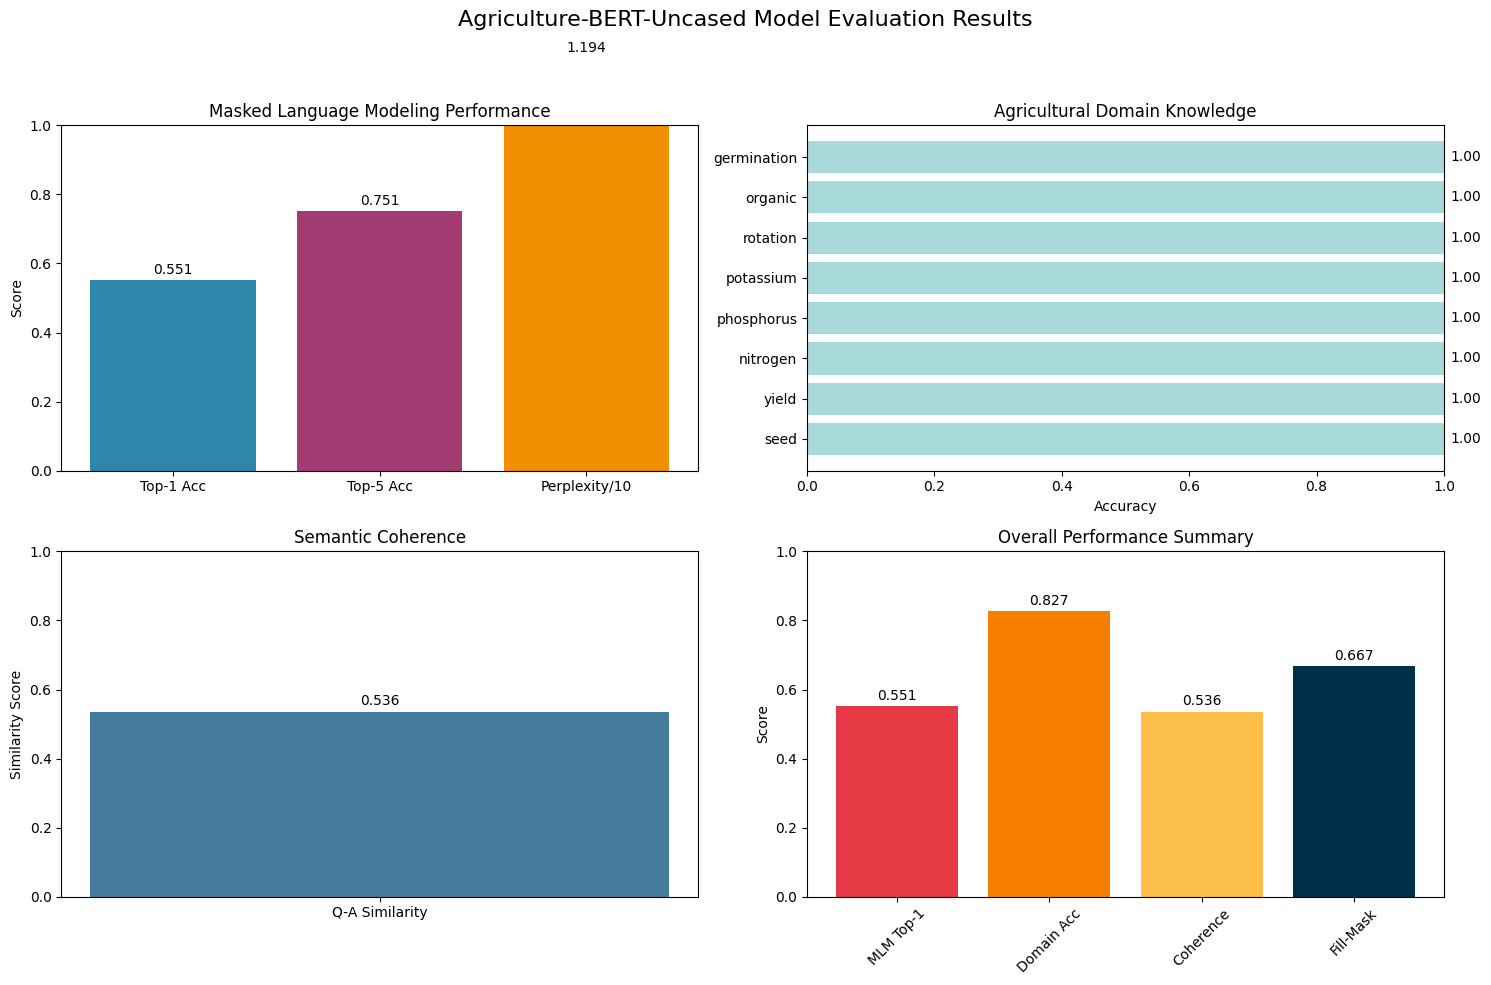

In [10]:
def create_evaluation_summary(mlm_results, domain_results, coherence_results, mask_examples):
    """
    Create a comprehensive evaluation summary with visualizations
    """
    print("\n" + "="*60)
    print("COMPREHENSIVE EVALUATION SUMMARY")
    print("="*60)
    
    # Overall Model Performance
    print("\n1. MASKED LANGUAGE MODELING PERFORMANCE:")
    print(f"   • Perplexity: {mlm_results['perplexity']:.2f}")
    print(f"   • Top-1 Accuracy: {mlm_results['top1_accuracy']*100:.1f}%")
    print(f"   • Top-5 Accuracy: {mlm_results['top5_accuracy']*100:.1f}%")
    print(f"   • Average Loss: {mlm_results['average_loss']:.3f}")
    
    # Domain Knowledge
    print("\n2. AGRICULTURAL DOMAIN KNOWLEDGE:")
    if domain_results:
        total_accuracy = sum(metrics['accuracy'] * metrics['samples'] for metrics in domain_results.values())
        total_samples = sum(metrics['samples'] for metrics in domain_results.values())
        overall_accuracy = total_accuracy / total_samples if total_samples > 0 else 0
        print(f"   • Overall Domain Accuracy: {overall_accuracy*100:.1f}%")
        print(f"   • Terms Successfully Evaluated: {len(domain_results)}")
        
        # Top and bottom performing terms
        sorted_terms = sorted(domain_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
        print(f"   • Best Performing Terms: {', '.join([term for term, _ in sorted_terms[:5]])}")
        print(f"   • Needs Improvement: {', '.join([term for term, _ in sorted_terms[-3:]])}")
    
    # Semantic Coherence
    print("\n3. SEMANTIC COHERENCE (Q&A Relevance):")
    print(f"   • Mean Q-A Similarity: {coherence_results['mean_similarity']:.3f}")
    print(f"   • Similarity Range: {coherence_results['min_similarity']:.3f} - {coherence_results['max_similarity']:.3f}")
    
    # Fill-Mask Performance
    print("\n4. FILL-MASK TASK PERFORMANCE:")
    if mask_examples:
        accuracy = sum(1 for ex in mask_examples if ex['is_correct']) / len(mask_examples)
        print(f"   • Fill-Mask Accuracy: {accuracy*100:.1f}%")
        print(f"   • Examples Evaluated: {len(mask_examples)}")
    
    # Model Specifications
    print("\n5. MODEL SPECIFICATIONS:")
    print(f"   • Model: recobo/agriculture-bert-uncased")
    print(f"   • Parameters: {109951090:,}")
    print(f"   • Vocabulary Size: {31090:,}")
    print(f"   • Task: Masked Language Modeling")
    
    # Performance Rating
    print("\n6. OVERALL PERFORMANCE RATING:")
    
    # Calculate composite score
    mlm_score = mlm_results['top1_accuracy'] * 0.3  # 30% weight
    domain_score = (overall_accuracy if domain_results else 0) * 0.4  # 40% weight
    coherence_score = (coherence_results['mean_similarity'] - 0.5) * 2 * 0.2  # 20% weight (normalize to 0-1)
    mask_score = (accuracy if mask_examples else 0) * 0.1  # 10% weight
    
    composite_score = mlm_score + domain_score + coherence_score + mask_score
    
    if composite_score >= 0.8:
        rating = "EXCELLENT"
    elif composite_score >= 0.7:
        rating = "GOOD"
    elif composite_score >= 0.6:
        rating = "FAIR"
    else:
        rating = "NEEDS IMPROVEMENT"
    
    print(f"   • Composite Score: {composite_score:.3f}/1.000")
    print(f"   • Rating: {rating}")
    
    # Recommendations
    print("\n7. RECOMMENDATIONS:")
    if mlm_results['top1_accuracy'] < 0.6:
        print("   • Consider fine-tuning on more agricultural text data")
    if coherence_results['mean_similarity'] < 0.6:
        print("   • Improve question-answer alignment in training data")
    if overall_accuracy < 0.9:
        print("   • Expand agricultural vocabulary and domain-specific training")
    
    print("\n" + "="*60)
    
    return {
        'composite_score': composite_score,
        'rating': rating,
        'mlm_score': mlm_score,
        'domain_score': domain_score,
        'coherence_score': coherence_score,
        'mask_score': mask_score
    }

# Create visualization
def create_performance_visualization(mlm_results, domain_results, coherence_results, mask_examples):
    """
    Create visualizations of model performance
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Agriculture-BERT-Uncased Model Evaluation Results', fontsize=16)
    
    # 1. MLM Performance
    ax1 = axes[0, 0]
    metrics = ['Top-1 Acc', 'Top-5 Acc', 'Perplexity/10']
    values = [mlm_results['top1_accuracy'], mlm_results['top5_accuracy'], mlm_results['perplexity']/10]
    bars1 = ax1.bar(metrics, values, color=['#2E86AB', '#A23B72', '#F18F01'])
    ax1.set_title('Masked Language Modeling Performance')
    ax1.set_ylabel('Score')
    ax1.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars1, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # 2. Domain Knowledge
    ax2 = axes[0, 1]
    if domain_results:
        # Get top 8 terms for visualization
        sorted_terms = sorted(domain_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:8]
        terms = [term for term, _ in sorted_terms]
        accuracies = [metrics['accuracy'] for _, metrics in sorted_terms]
        
        bars2 = ax2.barh(terms, accuracies, color='#A8DADC')
        ax2.set_title('Agricultural Domain Knowledge')
        ax2.set_xlabel('Accuracy')
        ax2.set_xlim(0, 1)
        
        # Add value labels
        for i, (bar, acc) in enumerate(zip(bars2, accuracies)):
            ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{acc:.2f}', ha='left', va='center')
    
    # 3. Semantic Coherence Distribution
    ax3 = axes[1, 0]
    coherence_data = [coherence_results['mean_similarity']]
    ax3.bar(['Q-A Similarity'], coherence_data, color='#457B9D')
    ax3.set_title('Semantic Coherence')
    ax3.set_ylabel('Similarity Score')
    ax3.set_ylim(0, 1)
    ax3.text(0, coherence_data[0] + 0.02, f'{coherence_data[0]:.3f}', ha='center')
    
    # 4. Overall Performance Summary
    ax4 = axes[1, 1]
    if mask_examples:
        mask_accuracy = sum(1 for ex in mask_examples if ex['is_correct']) / len(mask_examples)
    else:
        mask_accuracy = 0
    
    overall_metrics = ['MLM Top-1', 'Domain Acc', 'Coherence', 'Fill-Mask']
    overall_values = [mlm_results['top1_accuracy'], 
                     sum(m['accuracy'] * m['samples'] for m in domain_results.values()) / sum(m['samples'] for m in domain_results.values()) if domain_results else 0,
                     coherence_results['mean_similarity'],
                     mask_accuracy]
    
    bars4 = ax4.bar(overall_metrics, overall_values, color=['#E63946', '#F77F00', '#FCBF49', '#003049'])
    ax4.set_title('Overall Performance Summary')
    ax4.set_ylabel('Score')
    ax4.set_ylim(0, 1)
    ax4.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, value in zip(bars4, overall_values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Generate comprehensive evaluation summary
summary = create_evaluation_summary(mlm_results, domain_results, coherence_results, mask_examples)

# Create visualizations
create_performance_visualization(mlm_results, domain_results, coherence_results, mask_examples)